<a href="https://colab.research.google.com/github/vtu22874-eng/QML-Tasks/blob/main/TASK_9__Implement_a_QSVM_on_the_Iris_dataset_using_PennyLane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Aim: To implement a Quantum Support Vector Machine (QSVM) using PennyLane and scikit learn, where the quantum kernel is constructed from a quantum feature map, and evaluate its
performance on the Iris dataset for classification tasks.

Algorithm - QSVM Algorithm
1. Load dataset (Iris, 150 samples, 3 classes).
2. Preprocess
      Select features [sepal_length, sepal_width, petal_length, petal_width].
      Encode target labels numerically.
      Split dataset into train (67%) and test (33%).
3. Quantum Feature Map
      Apply Hadamard (H) gates to all qubits.
      Encode features into rotations 𝑅𝑍(𝑥).
      Add entanglement with 𝐶𝑁𝑂𝑇 +𝑅𝑍𝑥.𝑥 .
4. Quantum Kernel Construction
      Use kernel_circuit: apply 𝑈∅(𝑥), then adjoint𝑈∅(𝑥) .
      Measure overlap (fidelity).
5. Train QSVM
      Compute kernel matrix for training data.
      Train SVC(kernel = “precomputed”) using scikit-learn.
6. Test QSVM
      Compute test kernel matrix.
      Predict labels for test set.
7. Evaluate performance
      Confusion Matrix, Classification Report.
      Prediction for new point (4.4, 4.4, 4.4, 4.4).

In [ ]:
import requests

url = "https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9bf4cd8d2c9/iris.csv"
response = requests.get(url)
with open("iris.csv", "w") as f:
    f.write(response.text)

Column names in the dataframe: ['sepal.length', 'sepal.width', 'petal.length', 'petal.width', 'variety']

--- Feature Map Circuit (text) ---
0: ──H──RZ(0.55)─╭●───────────╭●─────────────────────────────────┤  State
1: ──H──RZ(0.80)─╰X──RZ(0.44)─╰X─╭●───────────╭●─────────────────┤  State
2: ──H──RZ(1.05)─────────────────╰X──RZ(0.84)─╰X─╭●───────────╭●─┤  State
3: ──H──RZ(1.58)─────────────────────────────────╰X──RZ(1.65)─╰X─┤  State

--- Feature Map Circuit (matplotlib) ---


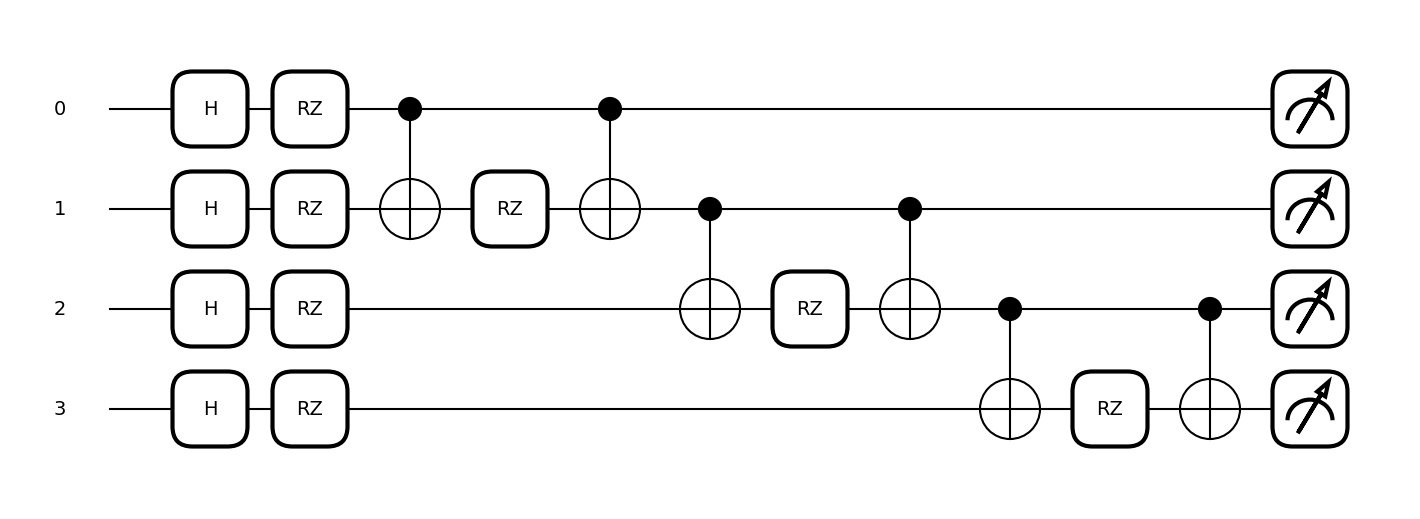


Computing training Gram matrix (this may take a bit)...
Computing test Gram matrix...

Confusion Matrix
[[15  0  1]
 [ 0 17  0]
 [ 0  2 15]]

Classification Report
                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.94      0.97        16
Iris-versicolor       0.89      1.00      0.94        17
 Iris-virginica       0.94      0.88      0.91        17

       accuracy                           0.94        50
      macro avg       0.94      0.94      0.94        50
   weighted avg       0.94      0.94      0.94        50


Predicted flower type for (4.4, 4.4, 4.4, 4.4): Iris-setosa


In [ ]:
# Single-file corrected script (error-free)
# Requirements (install beforehand):
#   pip install pennylane pandas scikit-learn matplotlib

import numpy as onp                       # Standard numpy for sklearn / arrays
import pennylane as qml
from pennylane import numpy as np        # pennylane's numpy for quantum calculations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# -------------------------------
# Load Iris dataset
# -------------------------------
# Ensure iris.csv is present in the working directory.
# The UCI dataset does not have a header, so we provide column names.
column_names = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width', 'variety']
df_iris = pd.read_csv("/content/iris.csv", header=None, names=column_names)

# Inspect column names to ensure they are correct
print("Column names in the dataframe:", list(df_iris.columns))

feature_cols = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
if not all(col in df_iris.columns for col in feature_cols):
    raise ValueError(f"Expected feature columns {feature_cols} not found in CSV. Found: {list(df_iris.columns)}")


X = df_iris[feature_cols].values.astype(float)
y = df_iris['variety'].values

# Encode labels into integers
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Optionally scale features (helps many ML algorithms)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# -------------------------------
# Define Quantum Feature Map
# -------------------------------
n_qubits = 4
if X.shape[1] != n_qubits:
    raise ValueError(f"Number of features ({X.shape[1]}) must equal n_qubits ({n_qubits}).")

dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    """Embedding classical features into a quantum state.
       x must be iterable with length == n_qubits.
    """
    # Ensure x is 1D array-like with correct length
    x = onp.asarray(x).flatten()
    if x.shape[0] != n_qubits:
        raise ValueError(f"feature_map expects input length {n_qubits}, got {x.shape[0]}")

    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[i], wires=i)

    # Add simple pairwise entanglement (ZZ-like)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
        qml.RZ(x[i] * x[i+1], wires=i+1)
        qml.CNOT(wires=[i, i+1])

# Circuit that returns the state vector for given input x
@qml.qnode(dev)
def state_circuit(x):
    feature_map(x)
    return qml.state()

# -------------------------------
# (Optional) Draw circuits for a sample pair
# -------------------------------
sample_x = x_train[0]
sample_y = x_train[1]

print("\n--- Feature Map Circuit (text) ---")
print(qml.draw(state_circuit)(sample_x))

print("\n--- Feature Map Circuit (matplotlib) ---")
fig, ax = qml.draw_mpl(state_circuit)(sample_x)
plt.show()

# -------------------------------
# Kernel (fidelity) and Gram matrix construction
# -------------------------------
def kernel(x1, x2):
    """Return fidelity between |Φ(x1)> and |Φ(x2)>:
       F = |<Φ(x1)|Φ(x2)>|^2
       We compute states via state_circuit and then fidelity.
    """
    # Convert to pennylane.numpy arrays for the qnode if necessary
    state1 = state_circuit(np.array(x1))
    state2 = state_circuit(np.array(x2))
    overlap = np.vdot(state1, state2)   # vdot handles complex conjugation correctly
    fidelity = np.abs(overlap)**2
    # convert fidelity to Python float
    return float(fidelity)

def compute_kernel_matrix(X1, X2):
    """Compute the Gram matrix K where K[i,j] = kernel(X1[i], X2[j])
       Returns a standard numpy.ndarray (float64) for sklearn compatibility.
    """
    n1 = len(X1)
    n2 = len(X2)
    K = onp.zeros((n1, n2), dtype=onp.float64)
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            K[i, j] = kernel(x1, x2)
    return K

# Compute kernel matrices
print("\nComputing training Gram matrix (this may take a bit)...")
K_train = compute_kernel_matrix(x_train, x_train)
print("Computing test Gram matrix...")
K_test = compute_kernel_matrix(x_test, x_train)

# -------------------------------
# Train QSVM (classical SVM with quantum kernel)
# -------------------------------
qsvm_model = SVC(kernel="precomputed", probability=False)
qsvm_model.fit(K_train, y_train)

# Predictions
y_pred = qsvm_model.predict(K_test)
print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# -------------------------------
# Test on a new input
# -------------------------------
# Provide new sample in the original feature scale; we must scale it using the same scaler used earlier.
raw_new_point = onp.array([4.4, 4.4, 4.4, 4.4], dtype=float).reshape(1, -1)
new_point_scaled = scaler.transform(raw_new_point)  # shape (1,4)

K_new = compute_kernel_matrix(new_point_scaled, x_train)  # shape (1, n_train)
pred_label = qsvm_model.predict(K_new)
print("\nPredicted flower type for (4.4, 4.4, 4.4, 4.4):", encoder.inverse_transform(pred_label)[0])

In [ ]:
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
response = requests.get(url)

if response.status_code == 200:
    with open("iris.csv", "w") as f:
        f.write(response.text)
    print("iris.csv downloaded successfully from UCI repository.")
else:
    print(f"Error downloading iris.csv from UCI repository. Status code: {response.status_code}")
    print("Content received:")
    print(response.text[:200]) # Print first 200 characters of the response content

iris.csv downloaded successfully from UCI repository.


In [ ]:
Result:
   Thus the program for implementing a qsvm on the dataset using pennylane were written, executed and verified successfully